In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [3]:
covidData = pd.read_csv("germanyCases.csv")
covidData['dates'] = pd.to_datetime(covidData['dates'])
covidData.head()

,Unnamed: 0,dates,confirmed,recovered,deaths,reinfection,vaccines_adm
0,1,2020-01-22,0,0,0,0,0
1,2,2020-01-23,0,0,0,0,0
2,3,2020-01-24,0,0,0,0,0
3,4,2020-01-25,0,0,0,0,0
4,5,2020-01-26,0,0,0,0,0


In [4]:
# Population of the country with data
germanyPop = 83214427
# Tuning parameter for 'steepness' of optimistic projection
alpha = 1
t0 = 10
length = np.shape(covidData)[0]
# arctan fake projection of testing 
projected = np.floor(
    alpha * (
        1 - (10 * (((np.arctan(np.arange(740) - t0) + np.pi / 2) / np.pi) - 1))
    )
)
covidData['project'] = projected
covidData.head()

,Unnamed: 0,dates,confirmed,recovered,deaths,reinfection,vaccines_adm,project
0,1,2020-01-22,0,0,0,0,0,10.0
1,2,2020-01-23,0,0,0,0,0,10.0
2,3,2020-01-24,0,0,0,0,0,10.0
3,4,2020-01-25,0,0,0,0,0,10.0
4,5,2020-01-26,0,0,0,0,0,10.0


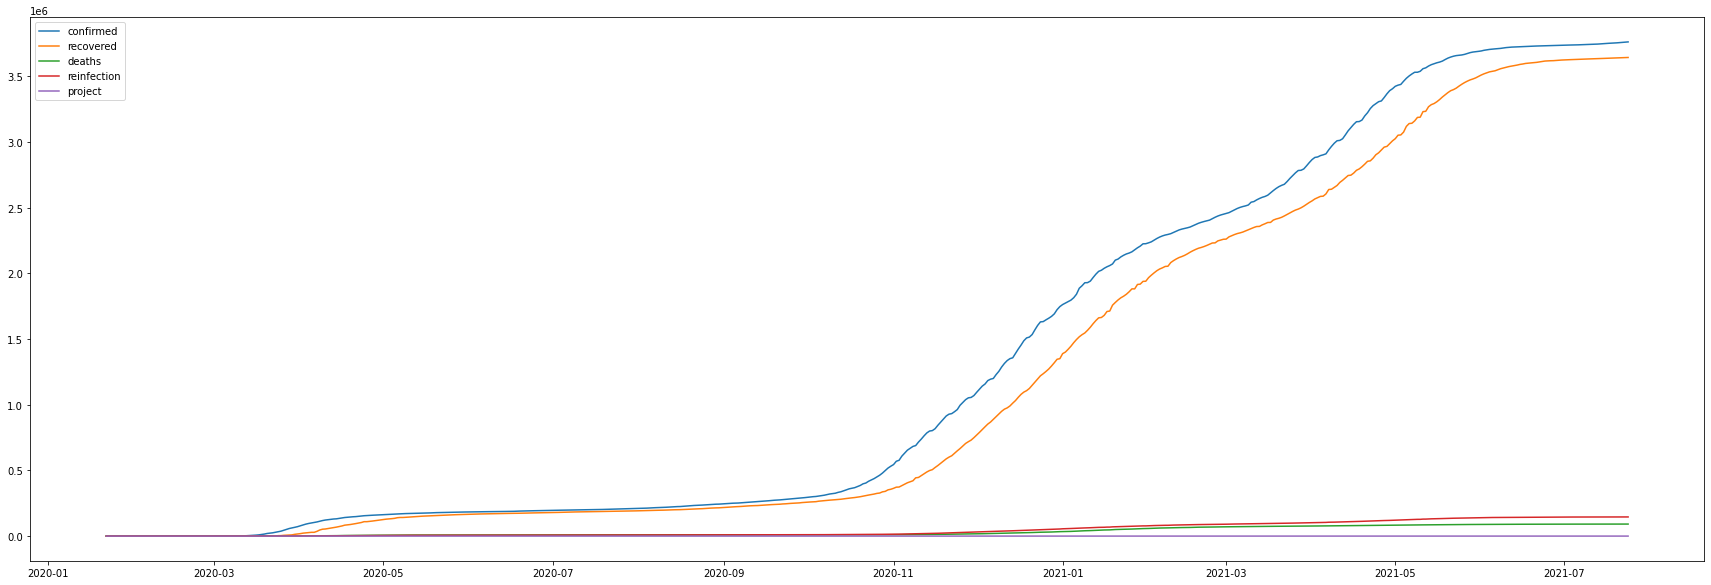

In [5]:
plt.figure(figsize = (30, 10))
cov = covidData.head(550)
plt.plot('dates', 'confirmed', data=cov)
plt.plot('dates', 'recovered', data=cov)
plt.plot('dates', 'deaths', data=cov)
plt.plot('dates', 'reinfection', data=cov)
plt.plot('dates', 'project', data=cov)
#plt.plot(covidData['dates'], germanyPop * np.ones(740))
plt.legend()

In [6]:
# Function for finding model parameters
def tuningParams(i, r, d, re, P):
    # Using definitions from the paper
    rho = 0.9
    e = 100000000000000000
    betaStar = 0
    gammaStar = 0
    nuStar = 0
    omegaStar = 0
    alphaStar = 0
    muStar = 0
    omega = np.arange(11) / 10
    alpha = np.arange(1, 101)
    for o in omega:
        for a in alpha:
            S = ((o / a) * P) - i - r - d - re
            delta = np.empty((1, 0))
            phi = np.empty((0, 4))
            for t in np.arange(100, 550):
                delta = np.append(delta,
                        np.array([i[t + 1] - i[t],
                                  r[t + 1] - r[t],
                                  d[t + 1] - d[t],
                                  re[t+1] - re[t]]))
                phi = np.append(phi, 
                       np.array([[(S[t] * i[t])/(S[t] + i[t]), -1 * i[t], -1 * i[t], r[t]],
                                 [0, i[t], 0, -1 * r[t]], 
                                 [0, 0, (a) * i[t], 0], 
                                 [0, 0, 0, r[t]]]), axis=0)
            #Moore penrose inverse
            invPhi = np.linalg.pinv(phi)
            params = np.matmul(invPhi, delta)
            error = delta - np.matmul(phi, params)
            errorNorm = np.linalg.norm(error)
            #print(f'error = {errorNorm}, e  = {e}')
            if errorNorm < e:
                e = errorNorm
                betaStar = params[0]
                gammaStar = params[1]
                nuStar = params[2]
                muStar = params[3]
                omegaStar = o
                alphaStar = a
            #print(delta, phi)
    paramEstimates = np.array([betaStar, gammaStar, nuStar, muStar, alphaStar])
    return paramEstimates

vec = tuningParams(covidData['confirmed'], covidData['recovered'], covidData['deaths'], covidData['reinfection'], germanyPop)


In [7]:
vec

array([1.64886340e-02, 4.17627477e-03, 1.16559725e-05, 2.79609530e-04,
       9.00000000e+00])

In [8]:
i = covidData['confirmed'] 
r = covidData['recovered']
d = covidData['deaths'] 
re = covidData['reinfection']
sStar = [germanyPop]
iStar = [i[100]]
rStar = [r[100]]
dStar = [d[100]]
reStar = [re[100]]

for i in range(739):
    coef = (sStar[-1] * iStar[-1]) / (sStar[-1] + iStar[-1])
    sStar.append(sStar[-1] - vec[0] * coef)
    iStar.append(iStar[-1] + vec[0] * coef - vec[1] * iStar[-1] - vec[2] * iStar[-1] + vec[3] * rStar[-1])
    rStar.append(rStar[-1] + vec[1] * iStar[-1])
    dStar.append(dStar[-1] + vec[4] * vec[2] * iStar[-1])
    reStar.append(reStar[-1] + vec[3] * rStar[-1])

sTil = sStar
iTil = iStar
rTil = rStar
dTil = dStar
reTil = reStar

sPlot = []
iPlot = []
rPlot = []
dPlot = []
rePlot = []
j = 0

for i in range(len(covidData['dates'])):
    if i < 100 or i >=550:
        sPlot.append(None)
        iPlot.append(None)
        rPlot.append(None)
        dPlot.append(None)
        rePlot.append(None)
    else:
        sPlot.append(sStar[j])
        iPlot.append(iStar[j])
        rPlot.append(rStar[j])
        dPlot.append(dStar[j])
        rePlot.append(reStar[j])
        j += 1

sTil2 = []
iTil2 = []
rTil2 = []
dTil2 = []
reTil2 = []

for i in range(739):
    sAdd = np.multiply(0.5, np.add(sTil[i::], sStar[i::]))
    iAdd = np.multiply(0.5, np.add(iTil[i::], iStar[i::]))
    rAdd = np.multiply(0.5, np.add(rTil[i::], rStar[i::]))
    dAdd = np.multiply(0.5, np.add(dTil[i::], dStar[i::]))
    reAdd = np.multiply(0.5, np.add(reTil[i::], reStar[i::]))
    #print(len(sAdd), len(iAdd), len(rAdd), len(dAdd), len(reAdd))
    sTil2 = sTil[0:i]
    sTil2.extend(sAdd)
    iTil2 = iTil[0:i]
    iTil2.extend(iAdd)
    rTil2 = rTil[0:i]
    rTil2.extend(rAdd)
    dTil2 = dTil[0:i]
    dTil2.extend(dAdd)
    reTil2 = reTil[0:i]
    reTil2.extend(reAdd)

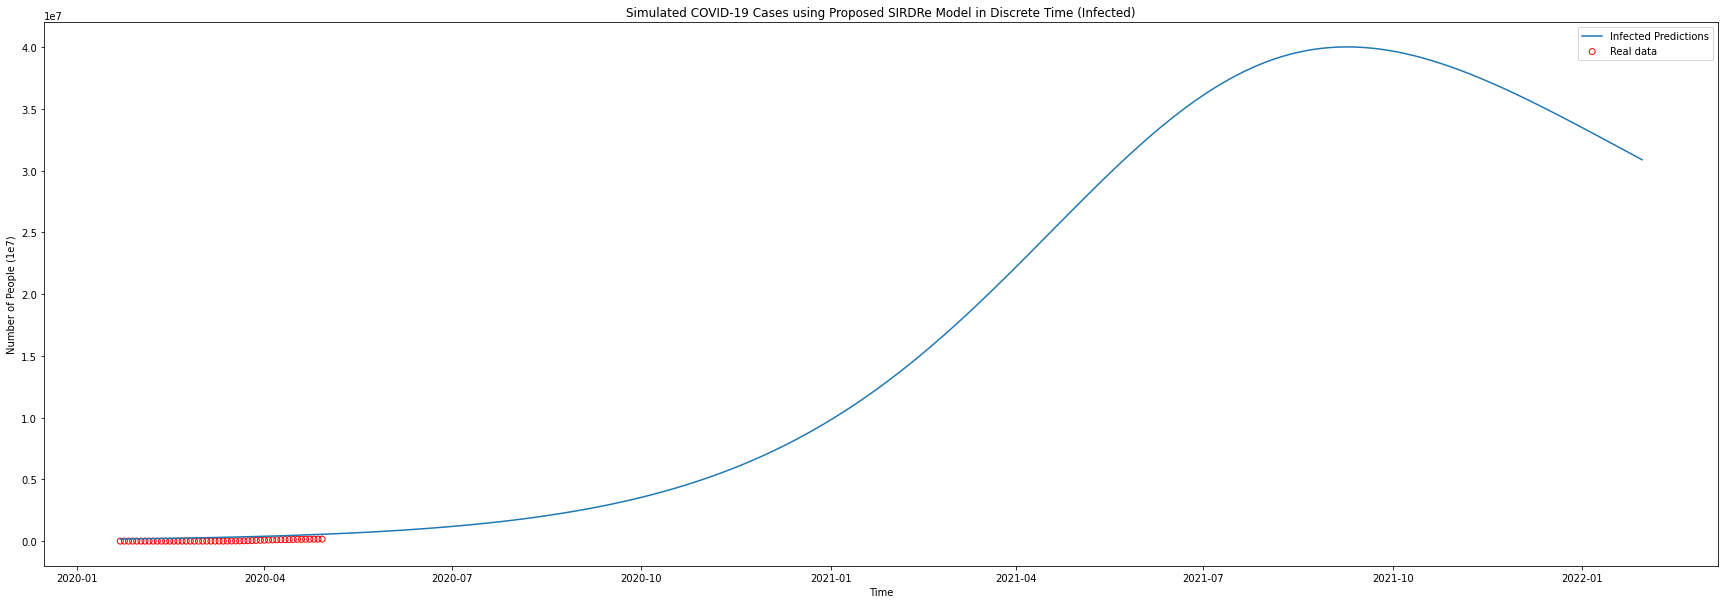

In [28]:
#print(len(sTil2), len(iTil2), len(rTil2), len(dTil2), len(reTil2))
#print("All done 3!")

plt.figure(figsize = (30, 10))
cov = covidData.iloc[0:100:2]
#plt.plot('dates', 'confirmed', data=covidData)

#Simulation of COVID-19 Cases 

# Convert dates to datetime

plt.locator_params(axis='x', nbins=50)

plt.plot(covidData['dates'], iTil2, label = 'Infected Predictions')
plt.scatter('dates', 'confirmed', data = cov, facecolors='none', edgecolors='r', label='Real data')
plt.title("Simulated COVID-19 Cases using Proposed SIRDRe Model in Discrete Time (Infected)")
plt.ylabel("Number of People (1e7)")
plt.xlabel("Time")
plt.legend()
plt.savefig('infections.jpg', dpi=300)
plt.show()

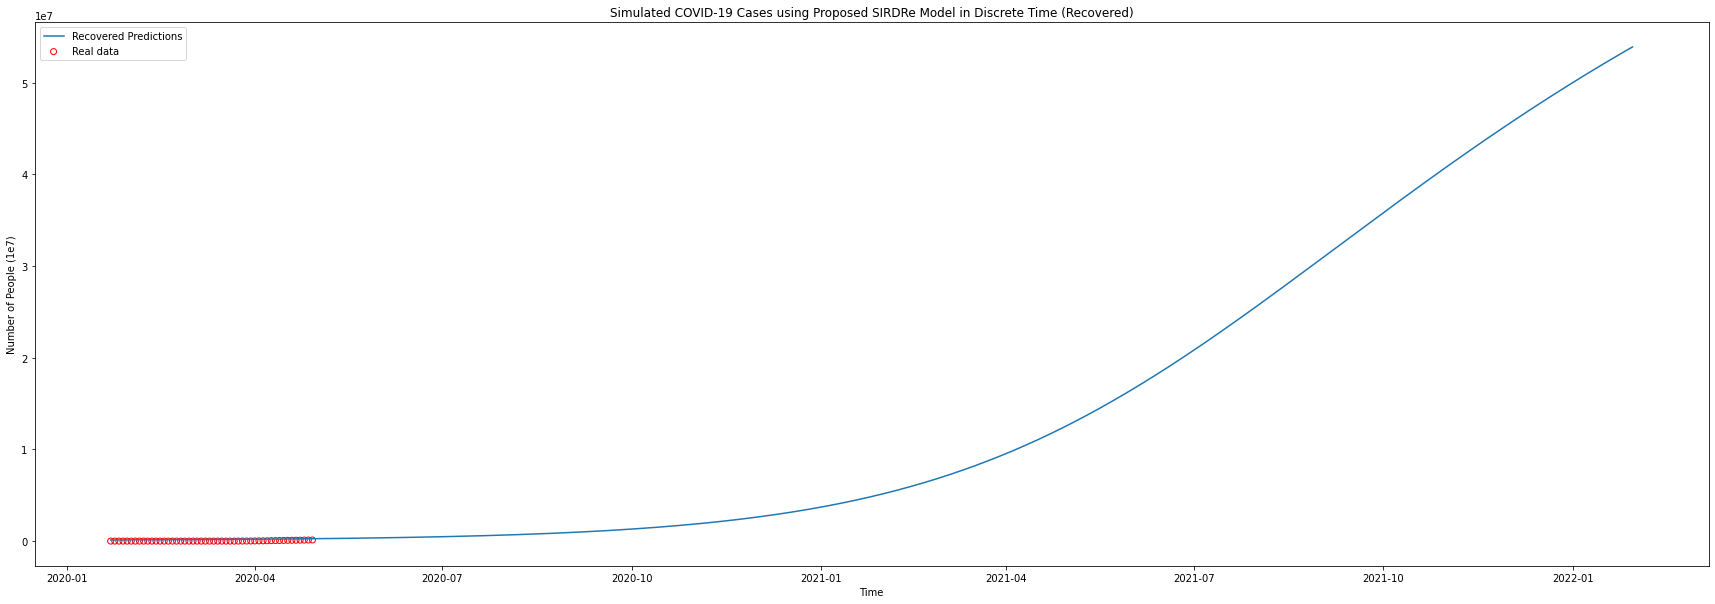

In [29]:
plt.figure(figsize = (30, 10))
plt.plot(covidData['dates'], rTil2, label = 'Recovered Predictions')
plt.scatter('dates', 'recovered', data = cov, facecolors='none', edgecolors='r', label='Real data')
plt.title("Simulated COVID-19 Cases using Proposed SIRDRe Model in Discrete Time (Recovered)")
plt.ylabel("Number of People (1e7)")
plt.xlabel("Time")
plt.legend()
plt.savefig('recovered.jpg', dpi=300, bbox_inches='tight')
plt.show()

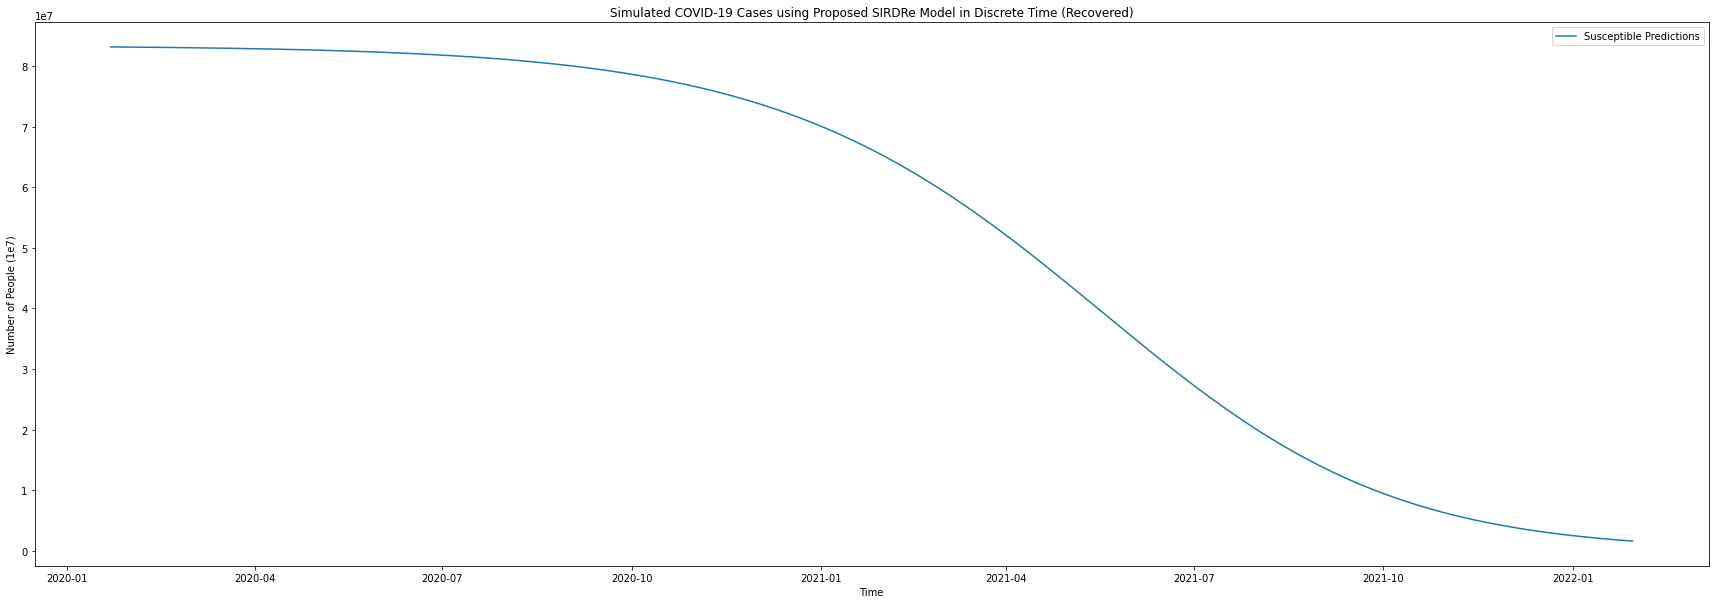

In [30]:
plt.figure(figsize = (30, 10))
plt.plot(covidData['dates'], sTil2, label = 'Susceptible Predictions')
#plt.scatter('dates', 'recovered', data = cov, facecolors='none', edgecolors='r', label='Real data')
plt.title("Simulated COVID-19 Cases using Proposed SIRDRe Model in Discrete Time (Recovered)")
plt.ylabel("Number of People (1e7)")
plt.xlabel("Time")
plt.legend()
plt.savefig('susc.jpg', dpi=300, bbox_inches='tight')
plt.show()

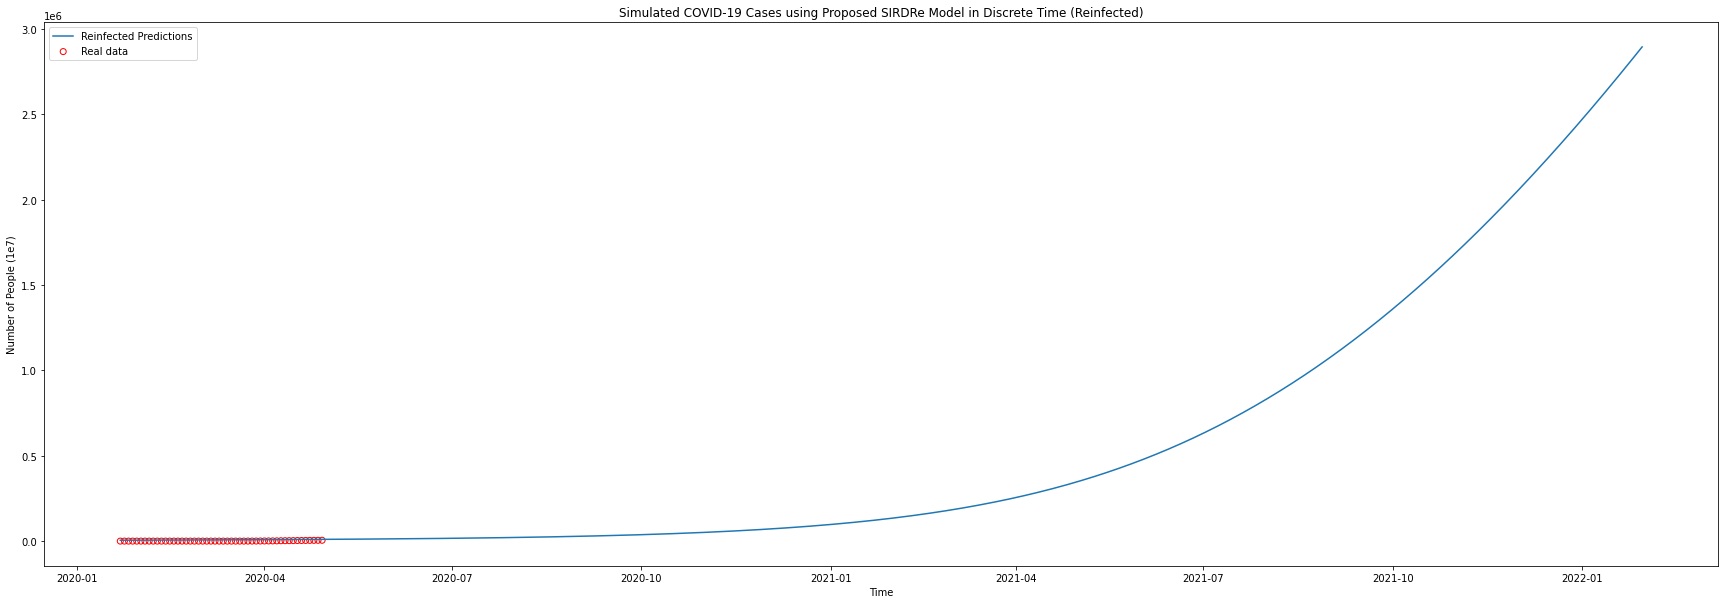

In [31]:
plt.figure(figsize = (30, 10))
plt.plot(covidData['dates'], reTil2, label = 'Reinfected Predictions')
plt.scatter('dates', 'reinfection', data = cov, facecolors='none', edgecolors='r', label='Real data')
plt.title("Simulated COVID-19 Cases using Proposed SIRDRe Model in Discrete Time (Reinfected)")
plt.ylabel("Number of People (1e6)")
plt.xlabel("Time")
plt.legend()
plt.savefig('reinfected.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [181]:
# Plot phase planes with experimental values

bs0 = vec[0] * germanyPop
D = np.sqrt(bs0**2 + 4 * bs0 * vec[3])
eig = ((0.5) * (-bs0 + D), (0.5) * (-bs0 - D))
eig

(0.0002796095795929432, -1372092.2319970585)